This project will focus on utilizing unsupervised learning to classify authors by their respective texts. 

Using 100 science fiction novels from project gutenberg. 

Source: https://www.gutenberg.org/wiki/Science_Fiction_(Bookshelf)

In [118]:
import nltk
import pandas as pd
import numpy as np
import books_files as books 
from urllib import request

In [119]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

def text_cleaner(text_data):
    text = re.sub("[^a-zA-Z]",' ',text_data)
    text = text.lower()
    text = text.split()
    lmz = WordNetLemmatizer()
    text = [lmz.lemmatize(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

In [120]:
from io import StringIO

book_text = []
authors = []

for k,v in books.url_dict.items():
    for url in v:
        response = request.urlopen(url)
        raw = response.read().decode('utf8')
        s = StringIO(raw)
        text_lines = []
        for i,line in enumerate(s):
            text_lines.append(line)
            if "START OF THIS PROJECT" in line:
                start_index = (i+1)
            if "END OF THIS PROJECT" in line:
                end_index = i
        book_text.append(' '.join(text_lines[start_index:end_index]))
        authors.append(k)

In [121]:
# 100 different books
print(len(book_text))

100


In [122]:
# 16 different authors
print(len(set(authors)))

16


In [123]:
text_df = pd.DataFrame()
text_df["Text"] = book_text
text_df["Author"] = authors
text_df["Author_ID"] = text_df["Author"].factorize()[0]
text_df.head(3)

,Text,Author,Author_ID
0,"\r\n \r\n \r\n \r\n Produced by Greg Weeks, Ma...",Anderson,0
1,\r\n \r\n \r\n \r\n Produced by Sankar Viswana...,Anderson,0
2,\r\n \r\n \r\n \r\n Produced by Sankar Viswana...,Anderson,0


In [124]:
# bag of words
corpus = []
for text in book_text:
    clean_text = text_cleaner(text)
    corpus.append(clean_text)
    #clean_text = nltk.word_tokenize(clean_text)
    #corpus.append(clean_text)

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_v = TfidfVectorizer(max_df=0.5,
                             min_df =2,
                             stop_words="english",
                             lowercase=False,
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

In [126]:
X = tfidf_v.fit_transform(corpus)
y = text_df.iloc[:,2].values

In [127]:
X.shape

(100, 18030)

In [128]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [129]:
X_train.shape

(75, 18030)

In [130]:
words = tfidf_v.get_feature_names()

Going to use cosine similarity to generate a measure of similarity between each book in the corpus (tf-idf matrix). We are subtracting the cosine similarity from 1 to get the cosine distance which will be used later on to plot the clusters on a euclidean 2D plane. 

In [131]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(X_train)

## KMeans Cluster

### Finding optimal number of clusters

In [132]:
# elbow method
from sklearn.cluster import KMeans
wcss = []
n_clusters = range(1,10)
for i in n_clusters:
    kmeans = KMeans(n_clusters=i,random_state=42)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

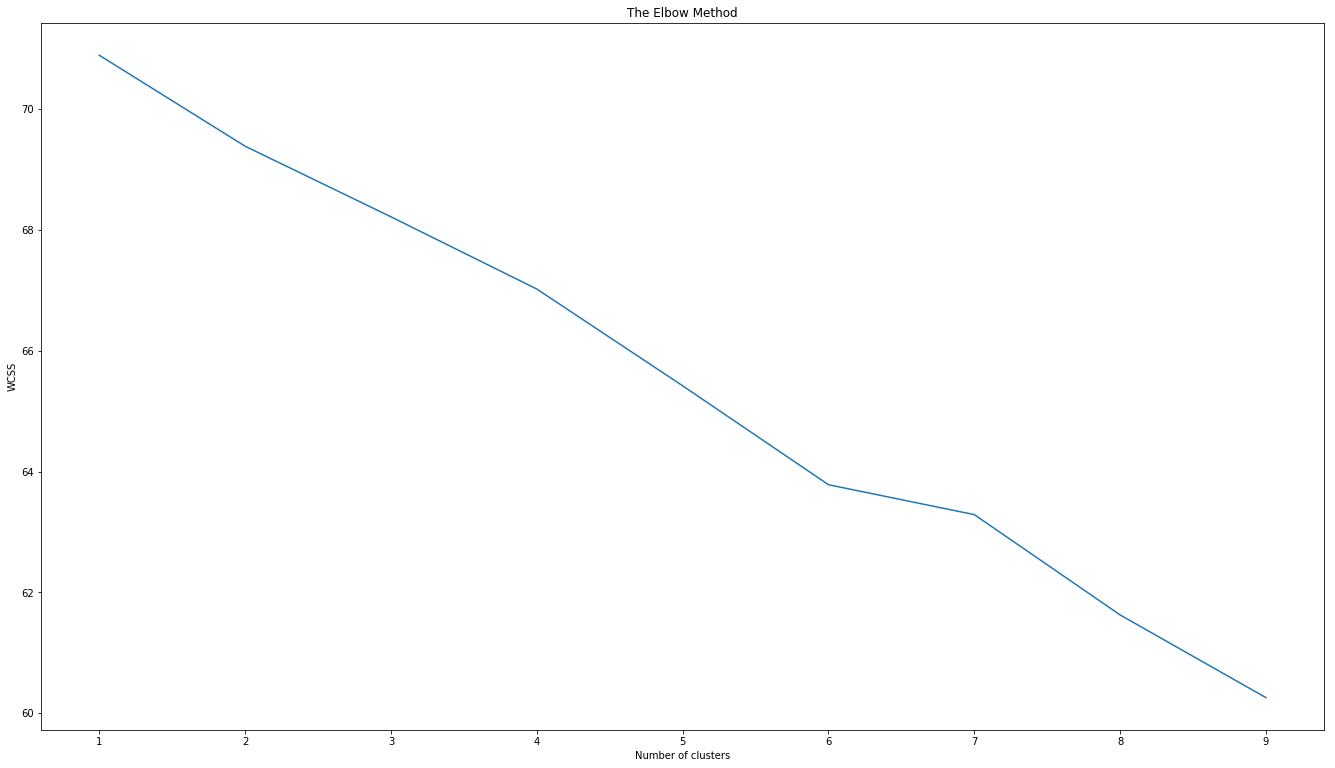

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (23,13)
plt.plot(n_clusters,wcss)
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.xticks(n_clusters)
plt.show()

In [134]:
# 6 clusters seems optimal
num_clusters = 6
km = KMeans(n_clusters=num_clusters,random_state=42)

In [135]:
km.fit(X_train)
clusters = km.labels_.tolist()

In [136]:
books = {"author":y_train,"book_text":X_train,"cluster":clusters}
frame = pd.DataFrame(books,index=[clusters],columns=["author","book_text","cluster"])

In [137]:
author_id = {}
for author in list(text_df["Author_ID"]):
    if author not in author_id:
        author_id[author] = text_df.loc[text_df["Author_ID"]==author,"Author"].iloc[0]
author_id

{0: 'Anderson',
 1: 'Ashwell',
 2: 'Beck',
 3: 'Breuer',
 4: 'Buckner',
 5: 'Budrys',
 6: 'Clifton',
 7: 'Cogan',
 8: 'Del Rey',
 9: 'Fyfe',
 10: 'Garrett',
 11: 'Leiber',
 12: 'Reynolds',
 13: 'Wells',
 14: 'Williams',
 15: 'Zagat'}

In [138]:
frame["cluster"].value_counts()

3    45
1     9
0     9
2     6
4     4
5     2
Name: cluster, dtype: int64

## Getting top 10 words and authors per cluster

In [139]:
from __future__ import print_function

print("Authors per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
cluster_names = {}

for i in range(num_clusters):
    cluster_names[i] = ""
    print("Cluster %d:"%i)
    print("Top 10 words:")
    for ind in order_centroids[i,:10]:
        cluster_names[i] += ("{} ".format(str(words[ind])))
        print("%s"%words[ind])
    cluster_names[i] = ','.join(cluster_names[i].split())
    print()
    print("Cluster %d authors:" % i, end='')
    for author in frame.loc[i]['author'].values.tolist():
        print(' %s,' % author_id[author], end='')
    print() #add whitespace
    print() #add whitespace

Authors per cluster:

Cluster 0:
Top 10 words:
henry
kennedy
guesser
zen
senator
aunt
robert
lieutenant
robot
kitty

Cluster 0 authors: Anderson, Clifton, Clifton, Del Rey, Garrett, Fyfe, Clifton, Williams, Clifton,

Cluster 1:
Top 10 words:
martian
mar
sand
jorgensen
ro
loaf
desert
meadow
bread
pete

Cluster 1 authors: Williams, Budrys, Anderson, Wells, Fyfe, Leiber, Williams, Leiber, Anderson,

Cluster 2:
Top 10 words:
joe
fisher
willard
smith
thinker
taranto
brett
calculator
max
ivar

Cluster 2 authors: Fyfe, Reynolds, Fyfe, Reynolds, Reynolds, Leiber,

Cluster 3:
Top 10 words:
dane
mead
moon
blade
dr
gordon
sea
colonel
porter
thompson

Cluster 3 authors: Budrys, Williams, Ashwell, Breuer, Wells, Cogan, Anderson, Leiber, Leiber, Del Rey, Budrys, Williams, Wells, Clifton, Leiber, Budrys, Budrys, Del Rey, Anderson, Anderson, Leiber, Zagat, Garrett, Garrett, Leiber, Fyfe, Leiber, Williams, Garrett, Williams, Garrett, Del Rey, Garrett, Wells, Del Rey, Cogan, Clifton, Anderson, Wells, Re

## Clusters visual (dimension reduction)

In [140]:
from sklearn.manifold import MDS

mds = MDS(n_components = 2,dissimilarity="precomputed",random_state=1)
pos = mds.fit_transform(dist)

In [141]:
xs,ys = pos[:,0],pos[:,1]

In [142]:
#set up colors per clusters using a dict
cluster_colors = {0: '#ffe059', 1: '#9cff07', 2: '#ff0707', 3: '#07ffc1', 4: '#a407ff',5: '#ff07bc'}

In [143]:
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, author=[author_id[i] for i in y_train])) 

groups = df.groupby('label')

/home/glenn/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


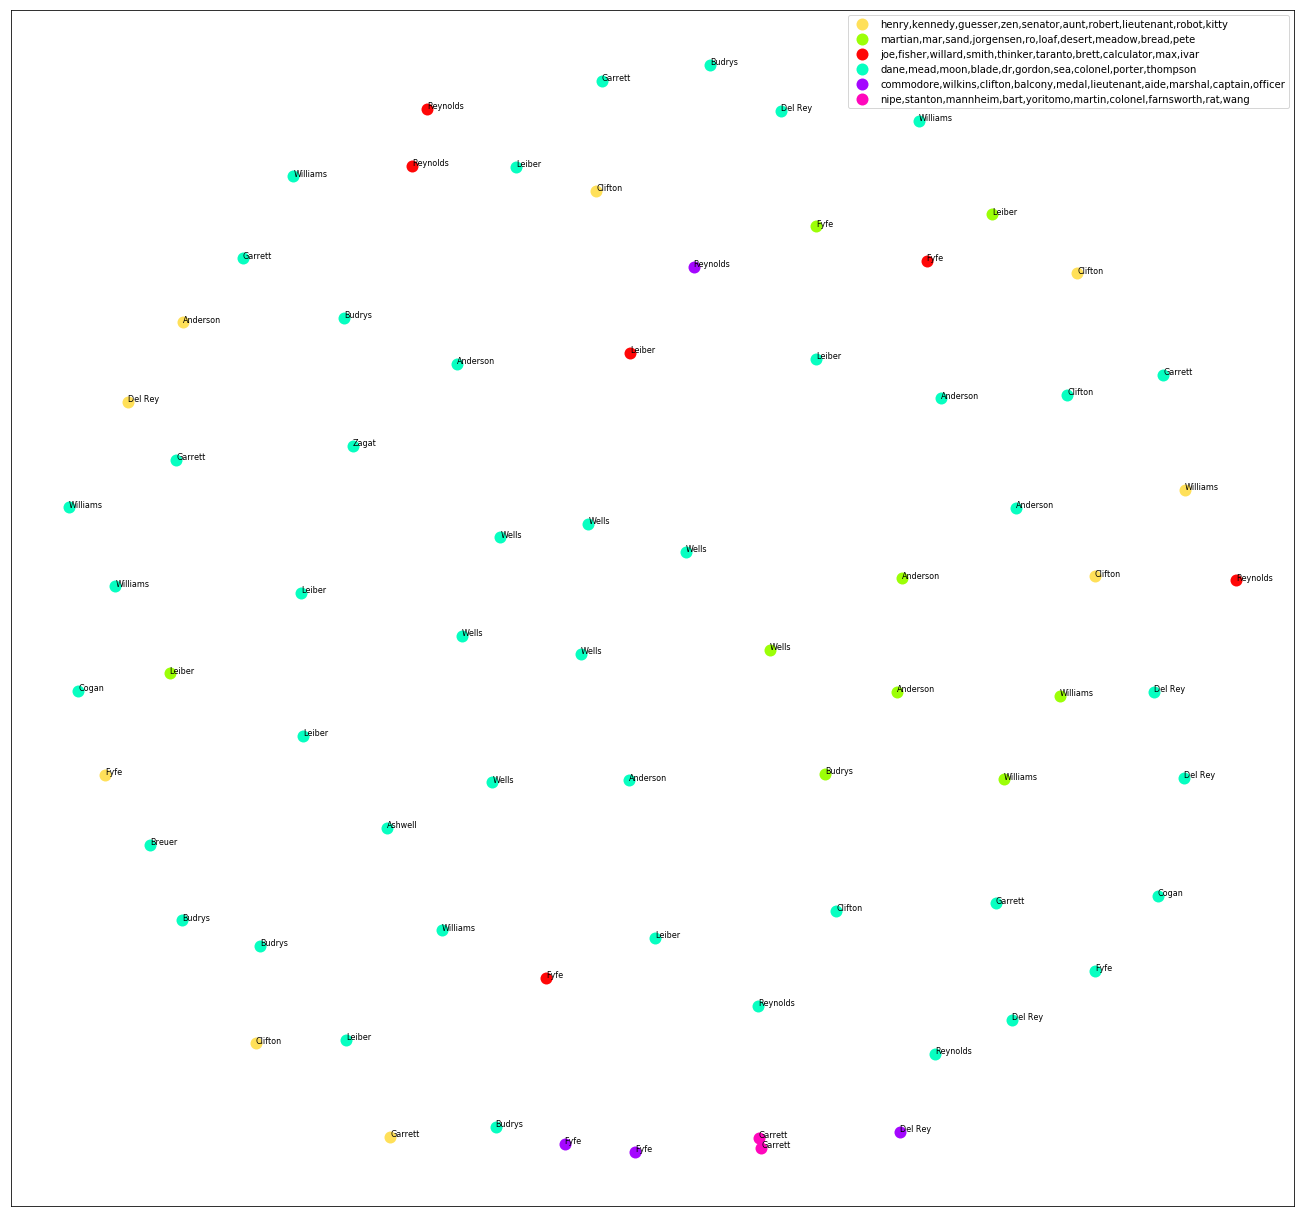

In [144]:
fig, ax = plt.subplots(figsize=(23, 22))

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='False',      # ticks along the bottom edge are off
        top='False',         # ticks along the top edge are off
        labelbottom='False')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='False',      # ticks along the bottom edge are off
        top='False',         # ticks along the top edge are off
        labelleft='False')

ax.legend(numpoints=1)  #show legend with only 1 point

for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['author'], size=8)  

plt.show()

## Visualizing Clusters with TSNE

T-distributed stochastic neighbor embedding (TSNE) minimizes the divergence between two distributions. 

In [145]:
X_train.shape

(75, 18030)

In [146]:
from sklearn.manifold import TSNE
#from sklearn.decomposition import TruncatedSVD

#k = 50
#tfs_reduced = TruncatedSVD(n_components=k,random_state=42).fit_transform(X_train)
tfs_embedded = TSNE(n_components=2,perplexity=40,init='pca',n_iter=2500,verbose=2,random_state=42).fit_transform(X_train.toarray())

[t-SNE] Computing 74 nearest neighbors...
[t-SNE] Indexed 75 samples in 0.002s...
[t-SNE] Computed neighbors for 75 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 75 / 75
[t-SNE] Mean sigma: 0.258095
[t-SNE] Computed conditional probabilities in 0.006s
[t-SNE] Iteration 50: error = 51.6268730, gradient norm = 0.5551164 (50 iterations in 0.059s)
[t-SNE] Iteration 100: error = 53.1243629, gradient norm = 0.5285240 (50 iterations in 0.050s)
[t-SNE] Iteration 150: error = 53.6908607, gradient norm = 0.4970714 (50 iterations in 0.055s)
[t-SNE] Iteration 200: error = 54.5841484, gradient norm = 0.4950770 (50 iterations in 0.049s)
[t-SNE] Iteration 250: error = 57.5701332, gradient norm = 0.5322967 (50 iterations in 0.051s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.570133
[t-SNE] Iteration 300: error = 0.9525703, gradient norm = 0.0033814 (50 iterations in 0.054s)
[t-SNE] Iteration 350: error = 0.7240608, gradient norm = 0.0019286 (50 i

In [147]:
tsne_group = pd.DataFrame(tfs_embedded,columns=['x','y']).assign(category=y_train).groupby('category')

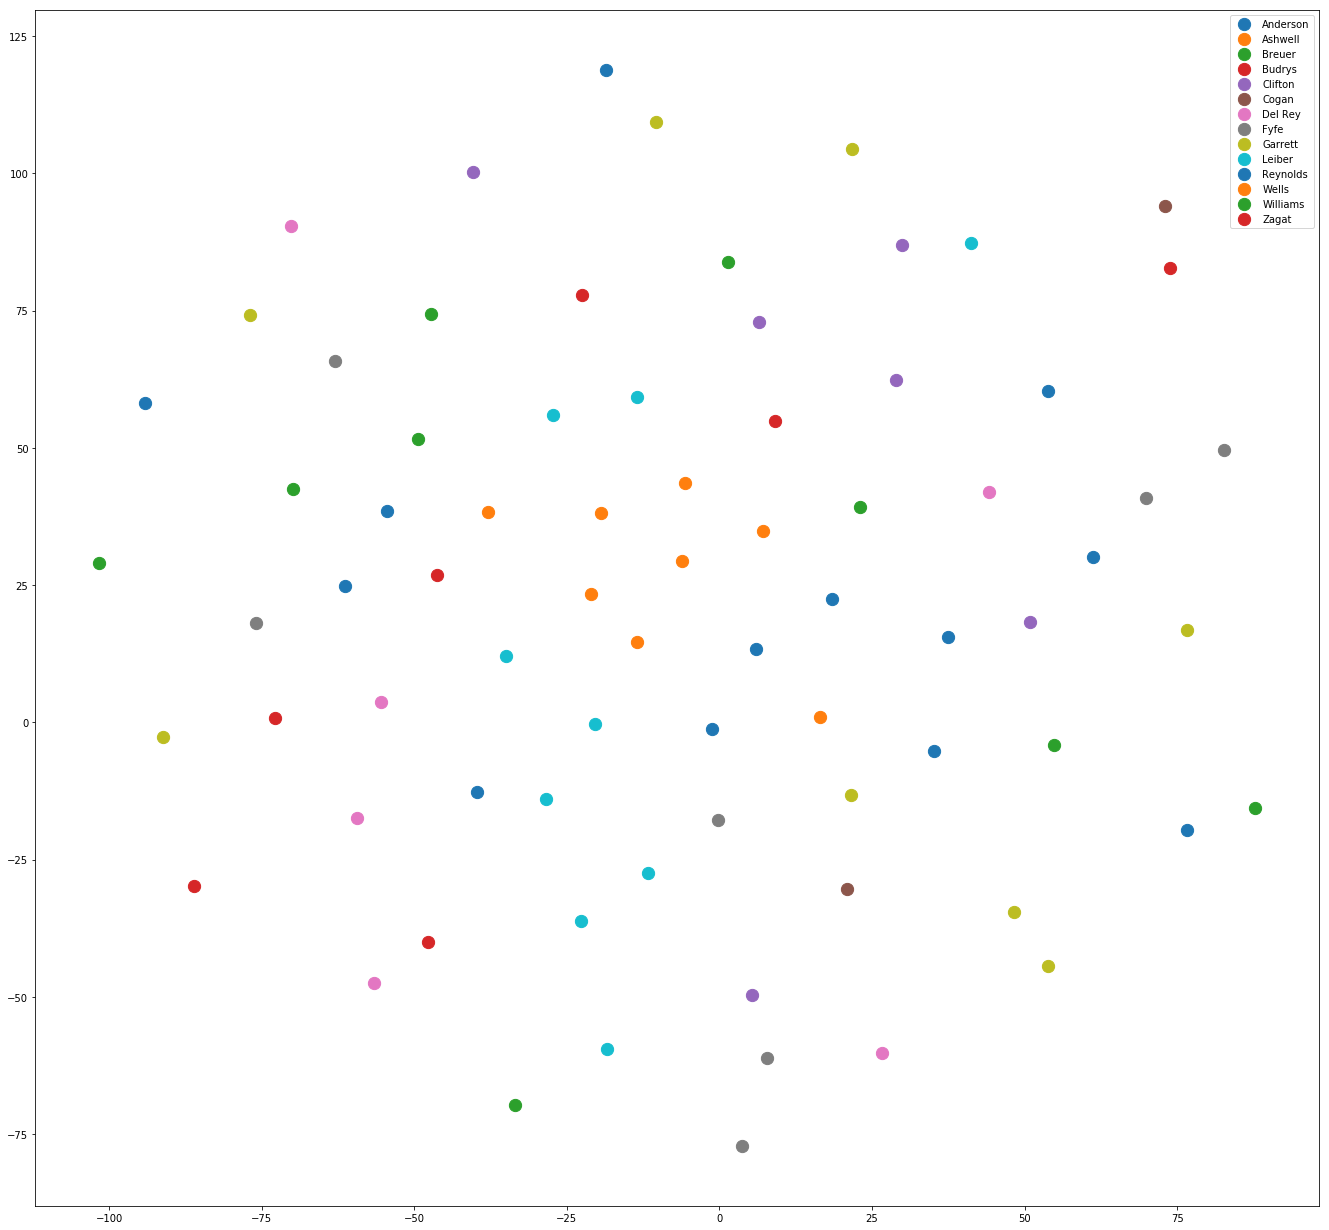

In [148]:
fig, ax = plt.subplots(figsize=(23, 22)) 

for name,points in tsne_group:
    ax.scatter(points.x,points.y,label=author_id[name],s=150)
    
ax.legend()
plt.show()

## Hierarchical Cluster visual

/home/glenn/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


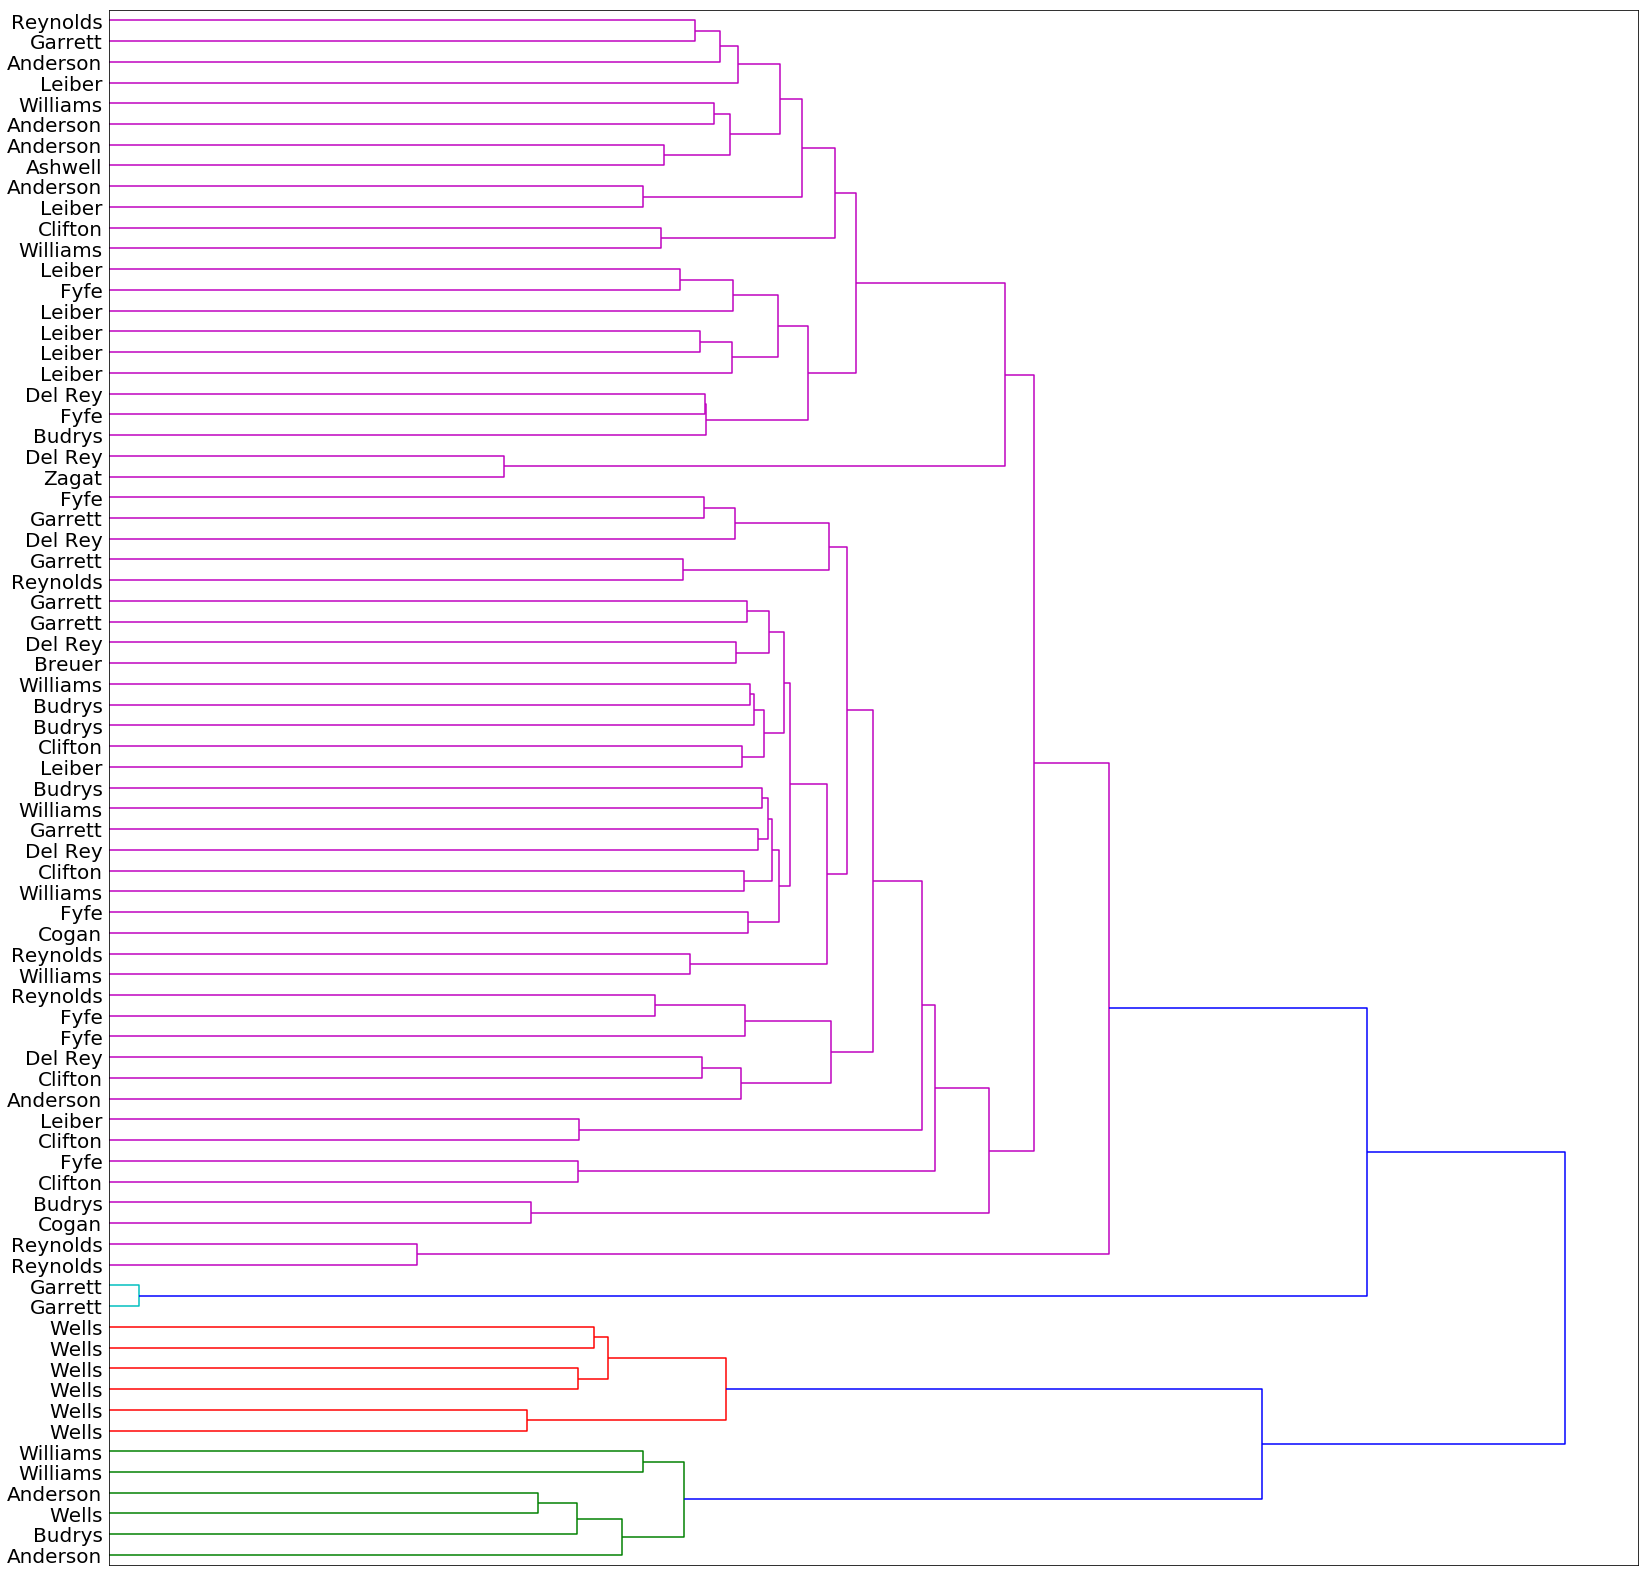

In [149]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(23, 22)) # set size

ax = dendrogram(linkage_matrix, orientation="right", labels=[author_id[i] for i in y_train]);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='False',      # ticks along the bottom edge are off
    top='False',         # ticks along the top edge are off
    labelbottom='False')
plt.tick_params(labelsize=20)
plt.tight_layout() #show plot with tight layout

In [150]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

## Applying supervised learning to model to classify texts by author

In [151]:
from sklearn.decomposition import TruncatedSVD

In [152]:
svd = TruncatedSVD(X_train.shape[1]-1)
X_svd = svd.fit_transform(X_train)

In [153]:
exp_var_ratio = svd.explained_variance_ratio_

In [154]:
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [155]:
X_svd.shape

(75, 75)

In [156]:
optimal_components = select_n_components(exp_var_ratio,0.95)
optimal_components

68

In [157]:
opt_svd = TruncatedSVD(optimal_components)
X_train_svd = opt_svd.fit_transform(X_train)
X_test_svd = opt_svd.transform(X_test)

In [158]:
exp_var_ratio2 = opt_svd.explained_variance_ratio_

In [159]:
total_variance = exp_var_ratio2.sum()

In [160]:
total_variance

0.9543426183041144

In [161]:
X_test_svd.shape

(25, 68)

#### Support Vector Classifier

In [162]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train_svd,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [163]:
print("Training set score: ",svc.score(X_train_svd,y_train))
print("Test set score: ",svc.score(X_test_svd,y_test))

Training set score:  0.12
Test set score:  0.04


In [164]:
from sklearn.model_selection import cross_val_score

cross_val_score(svc,X,y,cv=10)

/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


array([0.3125    , 0.45454545, 0.5       , 0.4       , 0.4       ,
       0.5       , 0.3       , 0.44444444, 0.5       , 0.66666667])

#### Logistic Regression

In [165]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train_svd,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [166]:
print("Training set score: ",lr.score(X_train_svd,y_train))
print("Test set score: ",lr.score(X_test_svd,y_test))

Training set score:  0.9466666666666667
Test set score:  0.24


In [167]:
cross_val_score(lr,X,y,cv=10)

/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


array([0.25      , 0.45454545, 0.5       , 0.5       , 0.6       ,
       0.5       , 0.4       , 0.55555556, 0.25      , 0.83333333])

#### Random Forest Classifier

In [168]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

rfc.fit(X_train_svd,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [169]:
print("Training set score: ",rfc.score(X_train_svd,y_train))
print("Test set score: ",rfc.score(X_test_svd,y_test))

Training set score:  1.0
Test set score:  0.08


In [170]:
cross_val_score(rfc,X,y,cv=10)

/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


array([0.25      , 0.45454545, 0.3       , 0.5       , 0.5       ,
       0.6       , 0.5       , 0.66666667, 0.625     , 0.33333333])

#### XGBoost

In [171]:
from xgboost import XGBClassifier

xgc = XGBClassifier()

xgc.fit(X_train_svd,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [172]:
print("Training set score: ",xgc.score(X_train_svd,y_train))
print("Test set score: ",xgc.score(X_test_svd,y_test))

Training set score:  1.0
Test set score:  0.16


/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [173]:
cross_val_score(xgc,X,y,cv=10)

/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is amb

array([0.5       , 0.81818182, 0.9       , 0.9       , 0.6       ,
       0.8       , 1.        , 0.88888889, 1.        , 0.83333333])